In [1]:
%matplotlib inline

In [54]:
# The following code is necessary for animated matplotlib videos
# Based on http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
# and on http://nbviewer.ipython.org/gist/edrex/9044756
# Important: The ffmpeg library needs to be installed to make this work http://www.ffmpeg.org/
from matplotlib import animation, pyplot as plt

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

# a bit ugly to use a global variable here
fps = 10
def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("tmp.mp4", fps=fps, extra_args=['-vcodec', 'libx264'])

        video = open("tmp.mp4","rb").read()
    plt.close()

    anim._encoded_video = video.encode("base64")
    return VIDEO_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

#HypTrails Tutorial

This ipython notebook provides a basic tutorial regarding the HypTrails approach. It utilizes the Python implementations provided at https://github.com/psinger/HypTrails and https://github.com/psinger/PathTools. HypTrails is a Bayesian approach that allows to compare hypotheses about human trails on the Web. Fundamentally, HypTrails is based on a first-order Markov chain model. Hypotheses are expressed as belief in parameters of the model. Then, HypTrails incorporates these hypotheses as elicited Dirichlet priors into a Bayesian inference process. The relative plausibility of hypotheses then is determined by their relative marginal likelihoods and Bayes factors.

Details about the paper initially presenting HypTrails as well as further information can be found at:
http://philippsinger.info/hyptrails.

First, this tutorial provides a short introduction to Bayesian inference which is necessary for understanding the main concepts of HypTrails. Then, a step-by-step example is elaborated which also takes excursions to related topics such as Markov chain models and Dirichlet distribution. Finally, a larger synthetic example is elaborated.

##Bayesian inference

Before we focus on how we can utilize Bayesian inference for comparing hypotheses about human trails with HypTrails, let us go through the basics of Bayesian inference. If you are already familiar with the basics of Bayesian statistics, feel free to completely skip this section (specifically, the coin flip example).

In general, statistical inference is the process of determining properties of a distribution by studying data. In our Markov chain case, this would mean that we e.g., want to determine the parameters (transition probabilities) given the data. Bayesian inference can be seen as the Bayesian counterpart to frequentist inference. In frequentist inference, parameters are usually seen as unknown constants and point estimates are inferred. An example of such point estimates is provided in the previous section where we have calculated the parameters by maximizing the likelihood (MLE). Contrary, Bayesian inference treats the model parameters as random variables and usually wants to deduce probabilistic statements about the distribution of parameters or also competing models or hypotheses. Bayesian inference utilizes the famous Bayes rule:

$$
 P(A|B) = \frac{P(B | A) P(A)}{P(B)}
$$

For model based inference, we can replace $A$ with the parameters $\theta$ and $B$ with the data $D$ at interest. Furthermore, we can introduce $I$ which can be used to introduce an additional assumption (knowledge) to the inference such as which model to use.

$$
 \overbrace{P(\theta| D, I)}^{\text{posterior}} = \frac{\overbrace{P(D | \theta, I)}^{\text{likelihood}}\overbrace{P(\theta|I)}^{\text{prior}}}{\underbrace{P(D|I)}_{\text{marginal likelihood}}}
$$

The prior distribution $P(\theta|I)$ specifies our assumption about the parameters $\theta$  before taking the data into account. The likelihood $P(D | \theta, I)$ represents the probability of the data if the parameters $\theta$ are specified. The marginal likelihood (or evidence) $P(D|I)$ is the distribution of the data $D$ given our additional assumption $I$. It is the normalization of the Bayes rule and plays an important rule for model comparison which HypTrails heavily utilizes and which we will talk about later in this tutorial. Finally, the posterior $P(\theta| D, I)$ is the distribution of the parameters after taking the observed data $D$ and our additional (prior) assumption $I$ into account. We can also say that the posterior is proportional to the likelihood and the prior.

$$
posterior \propto likelihood \times prior
$$

###Example: coin flip

####Introduction

For better understanding of Bayesian inference let us consider the classic coin flip example---we will go back to our football human trail example soon.

We are observing whether a coin flip results in "heads" or "tails". We are not sure whether the coin at interest is fair or whether it might be biased due to some asperity or similar things. Thus, we want to conduct statistical inference of the parameter $p$, which should describe the probability of flipping "heads", by utilizing the Bayesian framework. The probability of flipping "tails" is simply $1-p$. Further, we consider a set of observations $D$ by flipping the coin several times. Thus, by applying Bayes inference, we want to determine:

$$
P(p|D) \propto P(D|p) \times P(p)
$$

####Model

As underlying model, we can use the binomial distribution which is a discrete probability distribution for the number of successes in a sequence of n independent bianry experiments (e.g., coin flips resulting in "heads" or "tails"). The binomial distribution is conditioned on the parameters $n$ (number of trials) and $p$ the probability of flipping "heads". The probability mass function of the binomial distribution---which determines the probability of observing $k$ "heads" with parameters $p$ and $n$---is defined as:

$$
f(k|p,n) = \binom nk p^k (1-p)^{n-k}
$$
We can rewrite above Bayes rules as:

$$
P(p|k,n) \propto P(k|p,n) \times P(p)
$$

####Prior

We know how we can calculate the likelihood based on the PMF of the binomial distribution. But, how can we now use the prior? As mentioned, the prior is our belief in the parameter(s) before observing the data. So basically, we can express our assumption about the parameter $p$ in our model in the form of another probability distribution. In case of the binomial distribution as likelihood, we can use the Beta distribution as a  <a href="https://en.wikipedia.org/wiki/Conjugate_prior">conjugate prior</a>. This means that also the posterior distribution will be of the same family (i.e., Beta distribution) as the prior distribution.

The beta distribution is a continuous probability distribution over the interval $[0,1]$. The PDF of the Beta distribution is defined as:

$$
f(x|\alpha,\beta) =  \frac{1}{B(\alpha,\beta)} x^{\alpha-1}(1-x)^{\beta-1} =  \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, x^{\alpha-1}(1-x)^{\beta-1}
$$

$B$ is the <a href="https://en.wikipedia.org/wiki/Beta_function">beta function</a> and is a normalization constant to ensure that the probability integrates to 1. $\Gamma$ is the <a href="https://en.wikipedia.org/wiki/Gamma_function">gamma function</a>.

$\alpha$ and $\beta$ are positive shape parameters controlling the shape of the distribution. If they are $>=1$, we can think of them as pseudo counts; i.e., counts before observing the data. So for our example, this would mean that $\alpha$ would specify the pseudo counts of observing a "heads" flip, while $\beta$ would refer to the counts of observing a "tails" flip. The Wikipedia page of the <a href="https://en.wikipedia.org/wiki/Beta_distribution#Shapes">Beta distribution</a> goes into detail about the behavior of the shape parameters.

For a better understanding, let us visualize some examples next for the case of $\alpha >= 1$ and $\beta >= 1$. 

In [3]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

# helper function for plotting
def plot_beta(a,b,ax, print_interval=True):
    ax.set_xlabel("p")
    ax.set_ylabel("probability density")
    x = np.linspace(0.00,1, 100)
    label = "$\\alpha= " + str(a) + ", \\beta=" + str(b) + "$"
    dist = beta(a,b)
    # plot density
    ax.plot(x, dist.pdf(x),
            lw=2, alpha=0.6, label=label)
    # determine the 95% HDI
    if print_interval:
        print "Interval containing 95% of the distribution: ", dist.interval(0.95)

Let us consider a symmetric Beta distribution. This means that we want to express our prior belief that the coin is fair. We can express this prior with the shape parameters $\alpha$ and $\beta$ which we can interpret as pseudo counts. As we have a fair belief, we set both shape parameters to the same value. Let us start with $\alpha=\beta=10$.

Interval containing 95% of the distribution:  (0.2886432479169988, 0.7113567520830012)


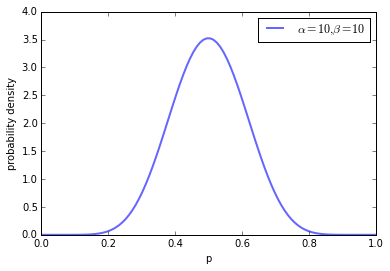

In [4]:
fig, ax = plt.subplots(1,1)
plot_beta(10,10,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

What we can see is the PDF of the Beta distribution with our given shape parameters. We can see that the parameter $p=0.5$ receives the highest density. However, as we keep our pseudo counts relatively low, we also allow other parameter configurations to receive a certain density. If we determine the interval containing 95% of the distribution, we receive $0.29$ as the lower and $0.71$ as the upper boundary.

Interval containing 95% of the distribution:  (0.43095093094181675, 0.56904906905818331)


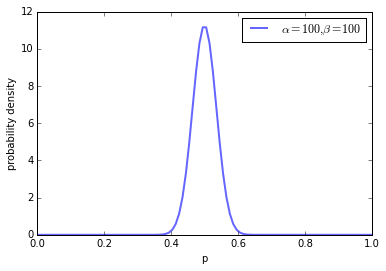

In [5]:
fig, ax = plt.subplots(1,1)
plot_beta(100,100,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

If we increase our symmetric shape parameters to a value of $100$, we can see a much higher density for parameters around the fair probability of $0.5$. The 95% highest density interval now lies between $0.43$ and $0.71$.

Interval containing 95% of the distribution:  (0.47809471962068506, 0.52190528037931494)


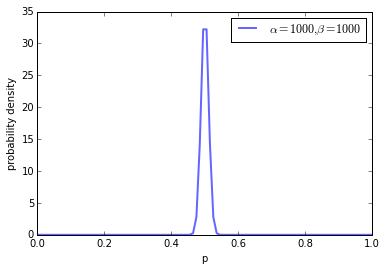

In [6]:
fig, ax = plt.subplots(1,1)
plot_beta(1000,1000,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

By further increasing the pseudo counts, we can further increase our "fair" coin belief.

Next, let us also shortly consider non-symmetric shape parameters (but let us still follow the pseudo count interpretation ant thus, only use parameters larger than one).

Interval containing 95% of the distribution:  (0.69150289218123928, 0.99747142145553824)


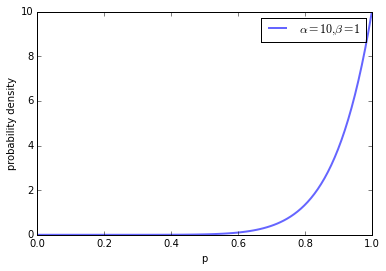

In [7]:
fig, ax = plt.subplots(1,1)
plot_beta(10,1,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

Setting $\alpha=10$ and $\beta=1$ increases the belief in an unfair coin biased towards flipping "heads". Finally, let us shortly consider what happens when we set $\alpha=\beta=1$.

Interval containing 95% of the distribution:  (0.025000000000000022, 0.97499999999999998)


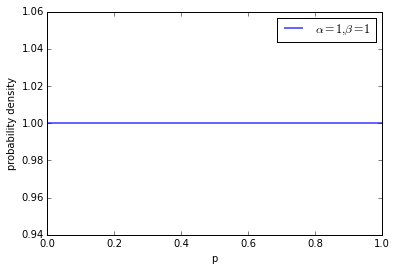

In [8]:
fig, ax = plt.subplots(1,1)
plot_beta(1,1,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

We can see that we now have a flat prior, meaning that all parameter configurations are equally likely. I suggest to play around with the shape parameters to see what happens with other configurations; also try to set the parameters lower than one.

####Posterior

Now that we have specified the likelihood-distribution as well as the prior-distribution we can rewrite the posterior-distribution as:

$$
P(p|k,n,\alpha,\beta) = \text{Beta}(p|\alpha+k, \beta+(n-k))
$$

As mentioned earlier, the posterior is from the same distribution family (Beta) as the prior (Beta), if the prior distribution is the conjugate prior to the likelihood distribution (binomial). For details about the derivation of this closed form of the posterior, please refer to this <a href="http://www.cs.cmu.edu/~10701/lecture/technote2_betabinomial.pdf">article</a>.

Thus, based on our Bayesian inference, the posterior distribution of the parameter $p$ indicating the probability of flipping "heads", is expressed as a Beta distribution. The parameters of this Beta distribution are constituted by both our a-priori assumptions---i.e., the hyperparameters $\alpha$ and $\beta$---as well as observed data---i.e., the number of times we flipped "heads" $k$ and "tails" $n-k$. The resulting posterior can then be used as a new prior as we gather more data.

For demonstrating how the posterior now changes with an increasing number of observations, let us assume that we know the parameter of flipping "heads" in advance---i.e., we manually assume $p$ of the binomial distribution to be $0.4$. For simplicity, let us assume that our inital Beta prior has the hyperparameters $\alpha=\beta=1$ meaning that we have no real a-priori tendency and work with a flat prior. Next, we incrementally sample single random variates from the binomial distribution with $p=0.4$ (Bernoulli trials) and update our posterior with corresponding samples.

In [9]:
from scipy.stats import beta, binom

# initializing plot
def init_plot():
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 1), ylim=(0, 13))
    line, = ax.plot([], [], lw=2)
    ttl = ax.text(0.6,0.8,'', transform = ax.transAxes, va='center', size=20)
    ax.set_xlabel("p")
    ax.set_ylabel("probability density")
    return fig, ax, ttl, line

# random variates
samples = binom.rvs(1,0.4, size=200)

# starting parameters and x values
a = 1
b = 1
x = np.linspace(0.00,1, 100)

# init function
def init():
    ttl.set_text("$\\alpha= " + str(a) + ", \\beta=" + str(b) + "$")
    y =  beta.pdf(x,a,b)
    line.set_data(x,y)
    return line,

# animating the stuff
def animate(i):
    global a,b
    # somehow the init frame is not drawn, so a small hack here
    if i != 0:
        a += samples[i-1]
        b += 1 - samples[i-1]
    ttl.set_text("$\\alpha= " + str(a) + ", \\beta=" + str(b) + "$")
    y =  beta.pdf(x,a,b)
    line.set_ydata(y)
    return line,

# let's animate
# you can increase/decrease the FPS at the beginning of this notebook
fig, ax, ttl, line = init_plot()
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

In above animation, we can see that with an increasing amount of random samples from the binomial distribution, starting with an initial uniform (flat) belief (prior), we increasingly belief in the true parameter (i.e., $p=0.4$) from the underlying distribution that we manually specified beforehand. Bayesian inference not only allows us to make statements about the most probable values for $p$, but also about the credibility of these statements (highest density regions).

What happens though, if we have stronger beliefs a-priori? Let us specify a Beta prior with $\alpha=50$ and $\beta=10$. Hence, we have decently high belief in a biased coin towards "heads", while our binomial distribution is slightly biased towards "tails" with $p=0.4$.

In [10]:
fig, ax, ttl, line = init_plot()
a = 50
b = 10
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

We can see, that with our 200 samples, our highest posterior belief is around $p=0.5$. This indicates the influence of the prior. Actually, the posterior can be seen as a convex combination of prior belief (pseudo counts) and the data ("heads" and "tails" counts). If our prior belief is strong, we need more data to "overrule" the prior. 

However, if we "steer" our prior in the right direction, we can increase our credibility around the "true" parameter, much faster.

In [11]:
fig, ax, ttl, line = init_plot()
a = 4
b = 6
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=1, blit=True)

You can play around with the parameters here. I also suggest to increase the prior pseudo counts to large numbers which results in the necessity to sample many variates to see differences regarding your prior knowledge (this may take a while though).

##Step-by-step example

Equipped with a basic understand about Bayesian inference, this tutorial now demonstrates the main methodological concepts and ideas of HypTrails. This should be achieved by going through a simple example step-by-step. 

###Introduction

Let us assume that we are the coach of a small football (soccer) team that---for simplicity---contains of three players (1, 2 and 3). We are interested in better understanding how our three players pass the ball between each other. To that end, we start to track the passes between our players which produce passing trails with each state of each trail corresponding to a player that has received the pass. For a better understanding, let us consider one sample trail depicted next.

In [12]:
from IPython.display import Image
Image(url="http://i.imgur.com/0K2oEh3.png")

In this example, player 1 first passes the ball to player 2 who then passes the ball to player 3. Finally, player 3 scores a goal and the trail is finished. Thus, this trail would look like:

Player 1 -> Player 2 -> Player 3

Of course, trails can be much longer. For example, player 3 might pass the ball back to player 2.

Having these kind of trails, we are now interested in better understanding the mechanisms producing these trails in order to make informed decisions regarding our team and our potential coaching focus. To that end, we come up with certain hypotheses about how our players prefer to pass the ball between each other and we want to relatively compare their plausibility.

###Markov chain model

Before we proceed, we need to introduce the underlying model that HypTrails is based on and which we utilize for modeling the data; the Markov chain model (see our <a href="http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0102070">PlosOne paper</a> for details). The MC model is a stochastic model that models transition probabilities---which are the parameters of the model---between states. In general, a Markov chain model is memoryless, which means that the next state in a trail only depends on the current one and not on a series of preceding states. We can write the Markov property as:

$$
 P(X_{t+1}=s_j|X_1=s_{i_1}, ..., X_{t-1}=s_{i_{t-1}}, X_t=s_{i_t})= \\ 
 P(X_{t+1}= s_j|X_t=s_{i_t}) = p_{i,j}.
$$

The following figure visualizes the various parameters of the model for our simple example.

In [13]:
Image(url="http://i.imgur.com/FR4fqqQ.png")

The players represent the various states and the arrows the parameters (transition probabilities) of the MC model. For example, $p_{2,1}$ represents the probability that player 2 will pass the ball to player 1 if player 2 currently is in possession of the ball. The parameters $p_{i,j}$ are usually expressed in a transition matrix with rows $i$ and columns $j$ representing the various states of the Markov chain. As this matrix is stochastic, it holds for all $i$ that:

$$
\sum_j p_{ij} = 1
$$

Each row of the transition matrix follows a <a href="https://en.wikipedia.org/wiki/Categorical_distribution">categorical probability distribution</a> (do not distinguish with multinomial distribution here). Hence, the likelihood for a Markov chain can be determined by a product of likelihoods for the individual categorical distributions---$n_{i,j}$ represents the number of times this transition occurs in the data:

$$
P(D | \theta) = \prod_i \prod_j p_{i,j}^{n_{i,j}}
$$

###Hypotheses

Elementary, we are interested in comparing hypotheses about human trails on the Web. This means that we come up with certain hypotheses that make assumptions about how our three players pass the ball between each other.
For example, we might hypothesize that our players pass the ball between each other based on their friendship status; i.e., good friends will pass the ball to each other more frequently. Or, we might hypothesize that players always pass the ball to the best player. But, how can we intuitively express these and similar generic hypotheses in a coherent way?

To that end, with HypTrails, hypotheses are expressed as Markov chain parameters (transitions) and our belief in them. This means, that according to a given hypothesis, we increase our belief in certain transitions if the hypothesis supports it. Note, we overall have three states; i.e., $S = {\text{Player 1}, \text{Player 2}, \text{Player 3}}$. This means that we have $|S|*|S|$ parameters; i.e., 9. Next, some examples are presented to give a better understanding about the process of expressing hypotheses with HypTrails. For these examples, we first gather some background information about the players and their relations.

In [14]:
from prettytable import PrettyTable

x = PrettyTable(["Player", "Market value", "Friendship to Player 1", "Friendship to Player 2", "Friendship to Player 3"])
x.add_row(["Player 1", "1000€", "x", "70", "30"])
x.add_row(["Player 2", "500€", "70", "x", "50"])
x.add_row(["Player 3", "800€", "30", "50", "x"])
print x

+----------+--------------+------------------------+------------------------+------------------------+
|  Player  | Market value | Friendship to Player 1 | Friendship to Player 2 | Friendship to Player 3 |
+----------+--------------+------------------------+------------------------+------------------------+
| Player 1 |    1000€     |           x            |           70           |           30           |
| Player 2 |     500€     |           70           |           x            |           50           |
| Player 3 |     800€     |           30           |           50           |           x            |
+----------+--------------+------------------------+------------------------+------------------------+


The market value should give us an indication about the strength of a player. The friendship relationship data is totally arbitrary here and might be initialized based on the personal feeling of us (being the coach of the players) based on a scale from 0 (worst enemies) to 100 (bff). We can then utilize this background knowledge to express our hypotheses as belief in Markov transitions. Note that the data utilized for expressing these hypotheses should not stem from the trail data studied because then we would already incorporate data into our hypotheses. Next, we want to express some exemplary hypotheses. Each hypothesis can be captured by a hypothesis matrix $Q$ with elements $q_{i,j}$ denoting the strength of our belief. The only limitations for the values are that they need to be positive and that higher values correspond to higher beliefs; normalization is conducted at a later point.

For the following examples, we will always assign zero belief to elements of the diagonal. We do this because we know that players pass the ball to other players all the time. If we would also somehow collect data that a player keeps the ball instead of passing it to another player, self-loops might happend and we might want to incorporate this into hypotheses at interest.

####Friendship hypothesis

Let us start with the friendship hypothesis, which believes that our players prefer to pass the ball to players they are friend with. This means that we want to increase values of $Q$ based on the friendship relations between the players. Thus, we can simply re-use the values provided in above table.

In [15]:
# First we need to build a vocabulary that assigns indices to state names
# This is necessary so that the HypTrails framework knows which rows and columns
# correspond to which player.
vocab = {"Player 1": 0, "Player 2": 1, "Player 3": 2}

# The HypTrails framework works with sparse scipy matrices
# Thus, we already start to specify them here
from scipy.sparse import lil_matrix, csr_matrix
# Building is better with a lil_matrix
q_friendship = lil_matrix((3,3))
q_friendship[vocab["Player 1"], vocab["Player 2"]] = 70.
q_friendship[vocab["Player 2"], vocab["Player 1"]] = 70.
q_friendship[vocab["Player 1"], vocab["Player 3"]] = 30.
q_friendship[vocab["Player 3"], vocab["Player 1"]] = 30.
q_friendship[vocab["Player 2"], vocab["Player 3"]] = 50.
q_friendship[vocab["Player 3"], vocab["Player 2"]] = 50.

# We need csr_matrices later
q_friendship = q_friendship.tocsr()
print q_friendship.todense()

[[  0.  70.  30.]
 [ 70.   0.  50.]
 [ 30.  50.   0.]]


####Market value hypothesis

With this hypothesis, we believe that players prefer to pass the ball to players with high market values. In teams like Barcelona or Real Madrid this would mean that players would prefer to pass the ball to Messi or C. Ronaldo followed by other players of the team ranked by their market value. Note that for this hypothesis, we do not differ between various start players (giving the pass). Regardless whether player 1, 2 or 3 starts to pass, we always believe that the pass will end at the players ranked by their market value. Again, for our small example, we can directly use the values provided in above table for our hypothesis matrix $Q$.

In [16]:
from scipy.sparse import lil_matrix, csr_matrix
q_market = lil_matrix((3,3))

q_market[:,0] = 1000.
q_market[:,1] = 500.
q_market[:,2] = 800.
# No self-loops
q_market.setdiag(0.)

# We need csr_matrices later
q_market = q_market.tocsr()
print q_market.todense()

[[    0.   500.   800.]
 [ 1000.     0.   800.]
 [ 1000.   500.     0.]]


####Uniform hypothesis

Finally, let us consider a uniform hypothesis which believes that all pass opportunities are equally likely. This can be seen as a baseline hypothesis.

In [17]:
from scipy.sparse import lil_matrix, csr_matrix
q_uniform = lil_matrix((3,3))
q_uniform[:] = 1.
# No self-loops (also for the uniform)
q_uniform.setdiag(0.)

# We need csr_matrices later
q_uniform = q_uniform.tocsr()
print q_uniform.todense()

[[ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]]


###Data

Now that we have our expressed hypotheses, we need to collect some data. As we do not really coach a three-player soccer team (too bad), we cannot work with real data here. So let us just create some arbitrary passing trails next.

In [18]:
trails = [
    ["Player 1", "Player 2", "Player 3", "Player 2", "Player 1"],
    ["Player 2", "Player 1", "Player 3", "Player 1", "Player 2"],
    ["Player 1", "Player 2", "Player 1", "Player 2", "Player 1", "Player 2", "Player 1"],
    ["Player 1", "Player 3"],
    ["Player 3", "Player 1", "Player 2", "Player 3", "Player 1", "Player 2", "Player 1"],
    ["Player 1", "Player 3", "Player 2", "Player 3", "Player 1", "Player 2", "Player 3", "Player 1", "Player 2"],
    ["Player 1", "Player 2", "Player 1", "Player 2", "Player 1", "Player 2"],
    ["Player 3", "Player 1"],
    ["Player 2", "Player 3", "Player 1", "Player 2", "Player 1", "Player 2", "Player 1", "Player 2"],
    ["Player 3", "Player 2", "Player 1"]
]

HypTrails directly works with the data provided above. For completeness, let us determine the maximum likelihood (see our <a href="http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0102070">PlosOne paper</a> for details) for the parameters which can be simply done by calculating:

$$
p_{ij} = \frac{n_{ij}}{\sum_j n_{ij}}
$$

The MLE can be seen as a parameter configuration that maximizes the likelihood of given data.

In [19]:
# PathTools includes the Markov chain functionality; see https://github.com/psinger/PathTools
from pathtools.markovchain import MarkovChain

# We initialize a first-order Markov chain model
# For details about the parameters please refer to the github repo and 
# the synthetic example presented later in this tutorial.
markov = MarkovChain(k=1, use_prior=False, reset = False, modus="mle")
markov.prepare_data(trails)
markov.fit(trails)

t = markov.transition_dict_
x = PrettyTable(["", "Player 1", "Player 2", "Player 3"])
x.add_row(["Player 1", t[("Player 1",)]["Player 1"], t[("Player 1",)]["Player 2"], t[("Player 1",)]["Player 3"]])
x.add_row(["Player 2", t[("Player 2",)]["Player 1"], t[("Player 2",)]["Player 2"], t[("Player 2",)]["Player 3"]])
x.add_row(["Player 3", t[("Player 3",)]["Player 1"], t[("Player 3",)]["Player 2"], t[("Player 3",)]["Player 3"]])
print x

+----------+----------+----------------+----------------+
|          | Player 1 |    Player 2    |    Player 3    |
+----------+----------+----------------+----------------+
| Player 1 |   0.0    | 0.833333333333 | 0.166666666667 |
| Player 2 |  0.6875  |      0.0       |     0.3125     |
| Player 3 |   0.7    |      0.3       |      0.0       |
+----------+----------+----------------+----------------+


In this table, we can see the transition probabilities (pass probabilities) between the three states (players) as determined by the maximum likelihood estimation. Due to the stochastic nature, each row sums to one. We can see that player 1 passes most of the time to player 2. Player 2 most of the time to player 1 (slightly more balanced) and player 3 also prefers to pass to player 1. We can also take a look at the raw transition counts.

In [20]:
# Using modus='bayes' is a small ugly trick here to get the raw transition counts
markov = MarkovChain(k=1, use_prior=False, reset = False, modus="bayes")
markov.prepare_data(trails)
markov.fit(trails)

t = markov.transition_dict_
x = PrettyTable(["", "Player 1", "Player 2", "Player 3"])
x.add_row(["Player 1", t[("Player 1",)]["Player 1"], t[("Player 1",)]["Player 2"], t[("Player 1",)]["Player 3"]])
x.add_row(["Player 2", t[("Player 2",)]["Player 1"], t[("Player 2",)]["Player 2"], t[("Player 2",)]["Player 3"]])
x.add_row(["Player 3", t[("Player 3",)]["Player 1"], t[("Player 3",)]["Player 2"], t[("Player 3",)]["Player 3"]])
print x

+----------+----------+----------+----------+
|          | Player 1 | Player 2 | Player 3 |
+----------+----------+----------+----------+
| Player 1 |   0.0    |   15.0   |   3.0    |
| Player 2 |   11.0   |   0.0    |   5.0    |
| Player 3 |   7.0    |   3.0    |   0.0    |
+----------+----------+----------+----------+


For players 1 and 2 we have a bit more data compared to passes starting from player 3.

Up to this point, we have expressed our hypotheses as beliefs in parameters and we have collected data. But, we do not know yet how we can make relative judgements about the plausibility of our hypotheses given the data. To that end, HypTrails resorts to Bayesian inference.

###Comparing hypotheses about human trails with HypTrails

So why have we spent so much time going through the basic of Bayesian inference in the beginning of this tutorial? Because we utilize it for comparing hypotheses about human trails. The main idea that we follow with HypTrails is that we want to incorporate hypotheses as priors into the inference process. The reason behind this is that the prior is exactly what our hypotheses should represent: <b>beliefs about parameters before observing the data</b>. 

In the coin flip example at the beginning of this tutorial, we have utilized the Beta prior as a conjugate prior to the binomial distribution. In this case, we work with a Markov chain model where each row of the transition matrix follows a categorical distribution (see beginning of this tutorial). The conjugate prior for the categorical distribution is the <a href="https://en.wikipedia.org/wiki/Dirichlet_distribution">Dirichlet distribution</a> which we will shortly describe next.

####Dirichlet prior

The Dirichlet distribution is a continuous multivariate probability distribution and is the multivariate generalization of the Beta distribution described earlier. Similar to the Beta distribution, the parameters of the Dirichlet distribution can be interpreted as pseudo counts when we consider values $>=1$ which we do throughout this tutorial. In detail, the Dirichlet distribution is now parametrized by a vector $\alpha=[\alpha_1, \alpha_2, ..., \alpha_n]$. The length of this vector is determined by the number of categories considered (or number of states for our Markov chain use case). Thus, the hyperparameters (pseudo counts) can represent our prior belief about the parameters of the Markov chain model; the higher we belief in them, the higher we want to set them. This means that the Dirichlet distribution represents probabilities of probabilities---or to be more precise, probabilties over probability configurations. For each row of our transition matrix, we thus have a Dirichlet prior defined by the following probability density function:

$$
Dir(\alpha_{i}) = \frac{\Gamma(\sum_j \alpha_{ij})}{\prod_j \Gamma(\alpha_{ij})}\prod_j p_{ij}^{\alpha_{ij} - 1}
$$

$\Gamma$ is the gamma function, $\alpha_j > 0$ for each $j$ and $\sum_j x_j = 1$ is a <a href="https://en.wikipedia.org/wiki/Simplex#Probability">probability simplex</a>. The probability outside of the simplex is $0$.

Similar as for the Beta distribution, let us visualize some exemplary settings for the parameters $\alpha$ of a Dirichlet distribution. For simplicity, let us consider that we only have three categories leading to the hyperparameters $\alpha=[\alpha_1, \alpha_2, \alpha_3]$ which steer our belief about the underlying parameters $p=[p_1, p_2, p_3]$. We start with a symmetric distribution where all elements of $\alpha$ have the same value. We start with setting all vaues of $\alpha$ to $1$ and increase these values by $1$ in each iteration. We visualize the resulting Dirichlet densities on the simplex.

In [21]:
# Many thanks to http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
# for providing the code for plotting Dirichlet distributions
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

In [22]:
# initializing plot
nlevels=200
subdiv=8
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)

# initializing plot
def init_plot():
    fig = plt.figure()
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    return fig

# init function
def init():
    dist = Dirichlet(alpha)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    plt.tricontourf(trimesh, pvals, nlevels)

# animating the stuff
def animate(i):
    para = f(alpha,i)
    plt.title("$\\alpha=["+ ",".join([str(x) for x in para]) + "]$")
    dist = Dirichlet(para)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    plt.tricontourf(trimesh, pvals, nlevels)

In [23]:
# let's animate
# you can increase/decrease the FPS at the beginning of this notebook
fig = init_plot()
alpha = [1, 1, 1]
f = lambda a,i: [x+i for x in a]
# change our ugly global fps variable
fps = 5
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=1, blit=True)

In this simplex, various parameter configurations are depicted. Note that these parameter configurations represent the $p$ values of our three state discrete distribution, not the hyperparameters $\alpha$ set for the Dirichlet distribution. This is similar to the Beta distribution which expresses the probability distribution of parameter configurations for the single parameter $p$ (e.g., flipping "heads"). So to note again, we have probabilities of probabilities.

Thus, the bottom left corner of the simplex corresponds to the parameter configuration $p=[1.0,0.0,0.0]$ while the bottom right corner represents the configuration $p=[0.0,1.0,0.0]$ and the top corner represents $p=[0.0,0.0,1.0]$. The most centric point corresponds to the $p=[1/3,1/3,1/3]$ configuration.

With our symmetric pseudo count configuration, we start with $\alpha_1=\alpha_2=\alpha_3=1$ and thus, we start with a flat prior that is uniform on the simplex meaning that all parameter configurations for $p$ are equally likely. However, with increasing concentration parameter (the sum of all values for $\alpha$), we increase our symmetric belief and decrease our belief for other parameter configurations. Thus, we stronger and stronger have high belief about the $p=[1/3,1/3,1/3]$ parameter configuration.

Let us consider another example, where we believe that $p_1$ and $p_3$ are equally important, while $p_2$ is unimportant. Thus, we increase the pseudo counts for $\alpha_1$ and $\alpha_3$ with each iteration and leave $\alpha_2=1$.

In [24]:
fig = init_plot()
alpha = [1, 1, 1]
f = lambda a,i: [a[0]+i, a[0], a[0]+i]
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=1, blit=True)

We can clearly see that the probability mass centers on the left side of the simplex which expresses parameter configurations that have high values for $p_1$ and $p_3$.

Again, I suggest to play around with the parameters. Note that for higher amounts of iterations (frames), the calculation will take some while.

####Eliciting Dirichlet priors from expressed hypoitheses

As mentioned, our idea is to incorporate hypotheses about human trails into the inference process as Dirichlet priors. The hyperparameters of the Dirichlet distribution can be interpreted as pseudo counts meaning that given a hypothesis, we want to set those pseudo counts high, that also have high values in expressed hypothesis. The overall amount of pseudo counts per distribution (concentration) can steer our amount of belief in a given hypothesis.

For elicitation, we have suggested to use an adapted version of the so-called (trial) roulette method in our original <a href="http://arxiv.org/abs/1411.2844">HypTrails paper</a>---for details please refer to the paper. The original (trial) roulette method is a
graphical method that allows experts to express their subjective belief
by distributing a fixed set of chips (think about casino chips you
set on a roulette table) to a given grid (e.g., bins representing result
intervals). The number of chips assigned to an element of the grid
then reflect the experts’ belief in the specific bin. Finally, a distribution can be fit to this chip distribution which can then be used as a prior distribution.

In our case, we already know which kind of distribution we want to utilize (Dirichlet) and we already have a grid: the individual transitions of the Markov chain. Initially, we also already have specified values for the hypothesis grid specified through expressed hypotheses matrices $Q$ (see beginning of this tutorial for details). Now, we have a further grid: the pseudo counts for our Dirichlet priors. Concretely, we want to automatically distribute a number of chips to the given pseudo counts  according to the values provided in matrix $Q$ expressing a hypothesis. We define the overall number of chips to distribute for a given hypothesis as:

$$
\beta = \overbrace{m^2}^{\text{flat prior}} + \underbrace{k\cdot m^2}_{\text{additional informative prior}}
$$

$m$ correspond to the number of states and $k$ can be interpreted as a hypothesis weighting factor. The higher we set $k$, the more we believe in a given hypothesis. This can be explained by the fact that with higher values of $k$, we distribute more chips to the Dirichlet priors. This means that the overall number of pseudo counts---i.e., the concentration parameter---increases. This concentrates the probability mass of the prior on fewer parameter configurations specified by the initial hypothesis (see Dirichlet behavior above). The initial flat prior is necessary to ensure proper priors and to allow our interpretation of Dirichlet hyperparameters as pseudo counts. Note that the number of chips to distribute is a suggestion and can be altered by researchers arbitrarily.

In a nutshell, HypTrails utilizes an adapted version of the (trial) roulette method for eliciting Dirichlet priors from expressed hypotheses. To that end, it fairly distributes a number of chips to the pseudo counts of the prior based on the values $q_{i,j}$ provided for a given hypothesis matrix $Q$.

Note: There are several ways one can elicit the Dirichlet priors from hypotheses matrices. One way---the one we have suggested in the original HypTrails paper---is to distribute a number of chips to the whole matrix. Basically, this method normalizes the whole matrix globally, and then fairly distributes the number of chips accordingly. This means that some rows might receive more chips (pseudo counts) than others. Thus, with this method, one is able to alter the amounts of beliefs per state (row) per hypothesis. With used HypTrails code, this can be achieved by passing the matrix and the total number of chips to the function ```distr_chips(matrix, chips, matrix_sum_final=None, norm=True)```.

Another, only slightly different way of distributing the chips, is to do it row-based. This function normalizes each row individually and distributes the same amount of chips (pseudo counts) to each row. Thus, we express a given hypothesis via equal amounts of belief for each state. In the rest of this tutorial, we will mostly resort to this row-based elicitation.

Most of the time, both methods will not show much difference in the large spectrum. Furthermore, notice that our proposed elicitation with help of the (adapted) trial roulette method can be replaced by other elicitation methods that someone might come up with. However, the main goal should always be to elicit the priors based on the expressed hypothesis and to steer the amount of belief regarding the hypothesis based on the concentration parameter. 

Next, let us elicit the priors from our expressed hypotheses at the beginning of this tutorial by utilizing the functionality provided in the HypTrails framework.

In [25]:
# for recap
print "friendship hypothesis"
print q_friendship.toarray()
print
print "market value hypothesis"
print q_market.toarray()
print
print "uniform hypothesis"
print q_uniform.toarray()

friendship hypothesis
[[  0.  70.  30.]
 [ 70.   0.  50.]
 [ 30.  50.   0.]]

market value hypothesis
[[    0.   500.   800.]
 [ 1000.     0.   800.]
 [ 1000.   500.     0.]]

uniform hypothesis
[[ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]]


In [26]:
# We import the necessary functionality
# trial_roulette contains methods for Dirichlet elicitation
from hyptrails.trial_roulette import *

In [27]:
# We start with the friendship hypothesis
# First, we specify the number of chips to distribute
# The flat prior part is done automatically in the Markov chain framework
# For the informative part, we start with k = 1
k = 1
# We multiply k with the number of states
# In this case we subtract one from the number of states as we do not allow self-loops
chips = k*(q_friendship.shape[0]-1.)
# Now, we distribute the chips
# We use the row-based method which is why we only specify the number of chips to be distributed per-row
# Hence, we do not square the number of states when calculating the number of chips
# Details about that are elaborated in a second
prior_friendship = distr_chips_row(q_friendship, chips, n_jobs=1)

# Let's check the elicited prior
print prior_friendship.toarray()

[[ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]]


Again, note that only the informative part is done here and the final inference adds one pseudo count to each hyperparameter for ensuring proper priors (see discussion above). In this simple example, we only distributed 2 chips to each row. This leads to the simple behavior of the (trial) roulette method to only assign 1 chip to the corresponding beliefs (see HypTrails paper for details) as no belief is strong enough to justify the assignment of 2 chips to it (because then the other belief of the row would not receive 1 chip). We can see here, that the concentration (sum of pseudo counts per row) is very low which means that our overall amount of belief in this hypothesis is low. This means that the highest density region of the simplex is quite large. To visualize the density of the Dirichlet priors, let us pick the third row of ```prior_friendship``` and visualize the simplex similar to as we did before when explaining the Dirichlet distribution.

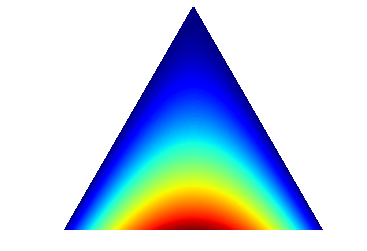

In [28]:
row = prior_friendship[2,:].toarray()[0]
# we need to add the uninformative part here
row = row + [1,1,1]
draw_pdf_contours(Dirichlet(row))

Now let us distribute more chips by increasing $k$.

In [29]:
k = 5
chips = k*(q_friendship.shape[0]-1.)
prior_friendship = distr_chips_row(q_friendship, chips, n_jobs=1)
print prior_friendship.toarray()

[[ 0.  7.  3.]
 [ 6.  0.  4.]
 [ 4.  6.  0.]]


With higher values of $k$ we increase the overall concentration of the Dirichlet distributions. Let us again plot the last row Dirichlet distribution.

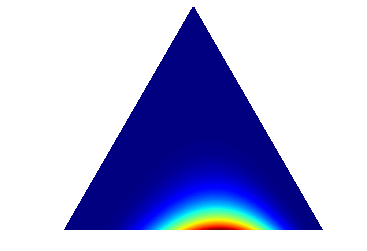

In [30]:
row = prior_friendship[2,:].toarray()[0]
# we need to add the uninformative part here
row = row + [1,1,1]
draw_pdf_contours(Dirichlet(row))

Now, we can already see that our belief centers to the belief that the third player (because we took the third row of the matrix) prefers to pass the ball to the first and second player. However, we have higher belief in passes to the second compared to the first player. Passes to the third player are not believed in at all, because we initially set the diagonal of $Q$ to zero as we do not consider self-loops.

For completeness, let us animate the behavior for the third Dirichlet prior by incrementally increasing $k$.

In [31]:
fig = init_plot()
# uninformative starting part
alpha = [1, 1, 1]

# distribute chips and pick the third row
def f(a,i):
    if i == 0:
        return a
    else:
        k = i
        chips = k*(q_friendship.shape[0]-1.)
        prior_friendship = distr_chips_row(q_friendship, chips, n_jobs=1)
        return prior_friendship[2,:].toarray()[0] + a

# change our ugly global fps variable
fps = 5
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=1, blit=True)

We can say, that with hypothesis matrix $Q$ we express a hypothesis that gives a direction of our belief. With hypothesis weighting factor $k$ we can influence the strength of this belief. With lower values, we give the hypothesis more tolerance to other parameter configurations that surround the single configuration specified in $Q$ and with higher values of $k$ we increase the concentration around this configuration.

Let us now also elicit the priors for our other two hypotheses with an exemplary value of $k=5$  and again visualize the third-row Dirichlet distributions.

[[ 0.  4.  6.]
 [ 6.  0.  4.]
 [ 7.  3.  0.]]


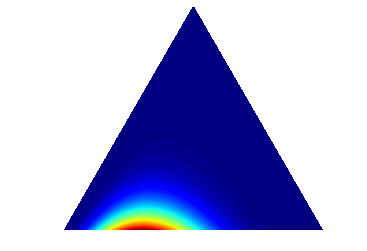

In [32]:
# Market hypothesis
k = 5
chips = k*(q_market.shape[0]-1.)
prior_market = distr_chips_row(q_market, chips, n_jobs=1)
print prior_market.toarray()

row = prior_market[2,:].toarray()[0]
# we need to add the uninformative part here
row = row + [1,1,1]
draw_pdf_contours(Dirichlet(row))

[[ 0.  5.  5.]
 [ 5.  0.  5.]
 [ 5.  5.  0.]]


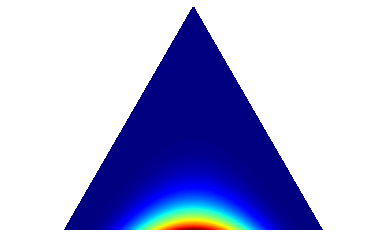

In [33]:
# Uniform hypothesis
k = 5
chips = k*(q_market.shape[0]-1.)
prior_uniform = distr_chips_row(q_uniform, chips, n_jobs=1)
print prior_uniform.toarray()

row = prior_uniform[2,:].toarray()[0]
# we need to add the uninformative part here
row = row + [1,1,1]
draw_pdf_contours(Dirichlet(row))

Note that the density of the uniform hypothesis does not concentrate at the center of the simplex due to our limitation that we do not allow self-loops.

For completeness, let us also shortly see what happens if we use the (trial) roulette method that distributes chips to the whole matrix.

[[ 0.  3.  5.]
 [ 7.  0.  5.]
 [ 7.  3.  0.]]


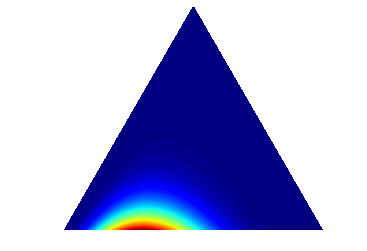

In [34]:
from math import pow
# Market hypothesis
k = 5
# now we specify the overall amount of chips
# again, self-loops are ignored
chips = k*(pow(q_market.shape[0],2)-3)
# whole matrix (trial) roulette method
prior_market = distr_chips(q_market, chips)
print prior_market.toarray()

row = prior_market[2,:].toarray()[0]
# we need to add the uninformative part here
row = row + [1,1,1]
draw_pdf_contours(Dirichlet(row))

Overall, we see the behavior of the prior is similar, however, different rows might slightly differ in their overall number of pseudo counts (concentration) which allows to steer individual beliefs per states by the values specified in $Q$.

####Marginal likelihoods and Bayes factors

After so much fuzz, you will ask yourself: "I still don't know how to make relative judgements about the plausibility of expressed hypotheses given data!". Fair point, which is why this tutorial finally provides the final puzzle part of HypTrails: the <b>marginal likelihood</b>.

Let us re-iterate Bayesian inference:

$$
 \overbrace{P(\theta| D, H)}^{\text{posterior}} = \frac{\overbrace{P(D | \theta, I)}^{\text{likelihood}}\overbrace{P(\theta|H)}^{\text{prior}}}{\underbrace{P(D|H)}_{\text{marginal likelihood}}}
$$

$\theta$ corresponds to the parameters of the Markov chain model, $D$ are the human trails at interest and $H$ corresponds to a hypothesis. We have said that we incorporate hypotheses as priors into the inference process. Thus, the priors (with pseudo counts) $P(\theta|H)$ differ for a given hypothesis. What we want to achieve now, is to determine which prior best reflects the given data. To that end, we utilize the marginal likelihood $P(D|H)$ (also called evidence) which we describe next.

The <a href="https://en.wikipedia.org/wiki/Marginal_likelihood">marginal likelihood</a> corresponds to the probability of the data given a hypothesis where the parameters have been marginalized out:

$$
P(D | H) = \int P(D | \theta, H)P(\theta | H)d\theta
$$

Note that $H$ corresponds to a specification of the hyperparameters of the Dirichlet priors based on given assumptions. So basically, the marginal likelihood is an average of the likelihood weighted by the prior, which is why we need to integrate the parameters out.

For our Markov chain model with a conjugate Dirichlet prior, the marginal likelihood is defined as (please consult our <a href="http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0102070">PlosOne paper</a> for derivation):

$$
P(D | H) = \prod_i\frac{\Gamma(\sum_j \alpha_{i,j})}{\prod_j \Gamma(\alpha_{i,j})} \frac{\prod_j \Gamma(n_{i,j}+\alpha_{i,j})}{\Gamma(\sum_j (n_{i,j}+\alpha_{i,j}))}
$$

For comparing the plausibility of two hypotheses, we resort to <a href="https://en.wikipedia.org/wiki/Bayes_factor">Bayes factors</a>. 
Bayes factors are representing a Bayesian method for model comparison that include a natural Occam's razor guarding against overfitting. In our case, a model represents a hypothesis at interest with each having different priors with different hyperparameters that express corresponding beliefs. For illustrative purposes, we are now interested in comparing hypotheses $H_1$ and $H_2$ where $H_1,H_2\in\textbf{H}$, given observed data $D$. We can define the Bayes factor---note that we apply unbiased comparison assuming that all hypotheses are equally likely a priori---as follows:

$$
B_{1,2} = \frac{P(D | H_1)}{P(D|H_2)}
$$

The strength of a Bayes factor can be determined by consulting the <a href="https://en.wikipedia.org/wiki/Bayes_factor#Interpretation">interpretation tables</a> of Jeffrey or Kass and Raftery.

The better a hypothesis is aligned with the data, the higher the evidence will be. For some examples of this behavior, please consult Section 2.3 of our <a href="http://arxiv.org/abs/1411.2844">HypTrails paper</a>. For having a fair comparison, we want to compare hypotheses with each other for the same values of the hypothesis weighting factor $k$.

###HypTrails in a nutshell

Now, the core concepts of HypTrails can be summarized by following visualization.

In [67]:
from IPython.display import Image
Image(url="http://i.imgur.com/EZTKWcc.png")

###Results

Now, that we know how HypTrails work, we can finally finish our experiments and discuss the results. We have already expressed our hypotheses, collected the data and we know how to elicit the priors. What is missing is the calculation of the marginal likelihoods.

In [36]:
from hyptrails.trial_roulette import *
def calc_evidence(matrix, trails, vocab, ax, label):

    shape_matrix = (max(vocab.itervalues()) + 1, max(vocab.itervalues()) + 1)
    
    # We iterate through some values of k (hypothesis weighting factor)
    evidences = {}
    for i in xrange(10):
        # If k = 0 then we can simply use an empty matrix
        if i == 0:
            prior = csr_matrix(shape_matrix, dtype=np.float64)
        # Otherwise, we need to build the hypothesis matrix and elicit the prior
        else:
            # Here we elicit the Dirichlet prior from expressed hypothesis matrix
            # We use the row-wise (trial) roulette chip distribution (i.e., same amount of chips for each row)
            # chips = number of chips to distribute PER ROW
            # The HypTrails paper suggests to distribute |S|*k chips per row.
            # As we ignore self-loops, we distribute (|S|-1)*k chips per row.
            chips = i*(matrix.shape[0]-1.)
            prior = distr_chips_row(matrix, chips, n_jobs=1)
            
        # Now, we can pass everything to the Markov chain framework and calculate corresponding evidences
        # k=1 corresponds to the order of the MC (first-order)
        # reset=False can be set to true if we want to work with a reset state (start end end state for each trail)
        # prior=1. corresponds to the initial uniform prior that is necessary for ensuring proper priors
        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, modus="bayes")
        markov.prepare_data(trails)
        markov.fit(trails)

        evidence = markov.bayesian_evidence()
        evidences[i] = evidence
    
    ax.plot(evidences.keys(), evidences.values(), marker='o', clip_on = False, label=label, linestyle='--')
    return evidences

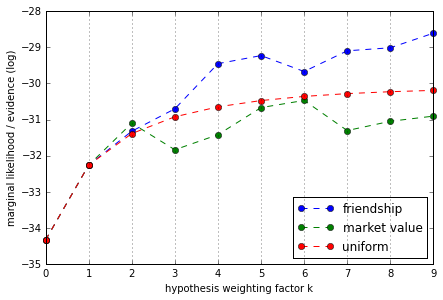

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Now, let us calculate the evidences
ret = calc_evidence(q_friendship, trails, vocab, ax, "friendship")

ret = calc_evidence(q_market, trails, vocab, ax, "market value")

ret = calc_evidence(q_uniform, trails, vocab, ax, "uniform")

# Let us also consider a data hypothesis which should be the best

markov = MarkovChain(k=1, use_prior=False, reset = False, modus="mle")
markov.prepare_data(trails)
markov.fit(trails)
mle = markov.transition_dict_

# Now we use the parameter configuration from the MLE as a hypothesis
i_indices = list()
j_indices = list()
values = list()
for s,targets in mle.iteritems():
    for t, v in targets.iteritems():
        i_indices.append(vocab[s[0]])
        j_indices.append(vocab[t])
        values.append(v)

q_data = csr_matrix((values, (i_indices, j_indices)),
                 shape=(len(vocab), len(vocab)), dtype=np.float64)

#ret = calc_evidence(q_data, trails, vocab, ax, "data")

# Further plotting
ax.set_xlabel("hypothesis weighting factor k")
ax.set_ylabel("marginal likelihood / evidence (log)")

plt.legend(loc=4, handlelength = 3)
plt.grid(False)
ax.xaxis.grid(True)
plt.tight_layout(pad=0.2)

In this figure, we can see on the x-axis the hypothesis weighting factor $k$ and on the y-axis the corresponding evidence. Each hypothesis is displayed in a different color. For $k=0$ all hypotheses have the same evidence as only the uninformative part is considered (all $\alpha=1$). We can compare the plausibility of hypotheses, by comparing the evidence values for the same values of $k$. Higher evidence means higher plausibility; calculating Bayes factors can determine the strength of these differences.

Not surprisingly, we can see that for all values of $k>0$ displayed, the data hypothesis is the most plausible one as it accurately represents the data studied. The most plausible hypothesis out of our set of real hypotheses is the friendship hypothesis which indicates the highest evidence values and also higher values compared to the uniform (baseline) hypothesis. The market value is the least plausible (at least for $k>2$).

The tendencies of the individual curves for rising values of $k$ give us indication of the relevance of this hypothesis with rising overall belief in this given hypothesis. The reason why the evidences of all hypotheses are in general rising with higher $k$ (even for the uniform) can be explained by the low number of states and small amount of data studied in this small toy example. As we explude the self-loop in all hypotheses, we already provide good explanations of the data as no self-loops are present there. The fluctuations regarding the evidences for rising values of $k$ (e.g., sometimes falling then rising again) can also be explained by the small amount of states and data at interest and the implementation of the (trial) roulette method; the general tendencies are clear though.

For completeness, the following graph shows how a self-loop hypothesis would behave.

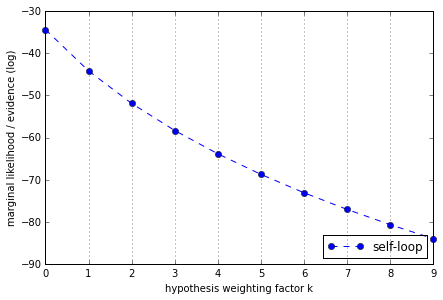

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
# And finally, also a self-loop hypothesis which should be the worst
q_selfloop = lil_matrix((len(vocab), len(vocab)), dtype=np.float64)
# As we only believe in self-loops we only believe in transitions from the diagonal of Q
q_selfloop.setdiag(1)
q_selfloop = q_selfloop.tocsr()

ret = calc_evidence(q_selfloop, trails, vocab, ax, "self-loop")
# Further plotting
ax.set_xlabel("hypothesis weighting factor k")
ax.set_ylabel("marginal likelihood / evidence (log)")

plt.legend(loc=4, handlelength = 3)
plt.grid(False)
ax.xaxis.grid(True)
plt.tight_layout(pad=0.2)

Here, we can clearly see, that the evidence of the self-loop hypothesis falls the higher we believe in it (higher $k$). 

In more large-scale examples, it might frequently happen that the evidence rises for lower values of $k$, but then falls. This indicates that the hypothesis goes into the right direction, but with higher belief in it, we limit ourself too much on it and do not assign other parameter configurations that might be important some probability. For a discussion about the behavior of the evidence for various $k$, please refer to Section 5 of our <a href="http://arxiv.org/abs/1411.2844">HypTrails paper</a>. Basically, interpretation should always be conducted dataset-independent and based on expressed hypotheses. 

##Synthetic example

In this example, we take a look at a more large-scale example. In detail, we create a synthetic graph and generate synthetic trails by letting a random walker walk through this graph. We then compare some hypotheses with each other which should further demonstrate the mechanics of HypTrails. We use the python code provided at https://github.com/psinger/HypTrails.

In [61]:
#First, we import the necessary functionality
#trial_roulette contains methods for Dirichlet elicitation
#PathTools includes the Markov chain functionality; see https://github.com/psinger/PathTools
from hyptrails.trial_roulette import *
from pathtools.markovchain import MarkovChain

In [62]:
#For running this example networkx is needed
import networkx as nx

###Synthetic data generation

First, we generate a random graph. To that end, we create a Barabasi-Albert random network with 13 nodes and new nodes are attached to the existing graph with 2 edges. The graph layout is visualized.

Note that this network is undirected. However, there are also extensions that allow to generate directed Barabasi-Albert networks. For simplicity, we focus on the undirected case here though.

In [63]:
g = nx.barabasi_albert_graph(13, 2)

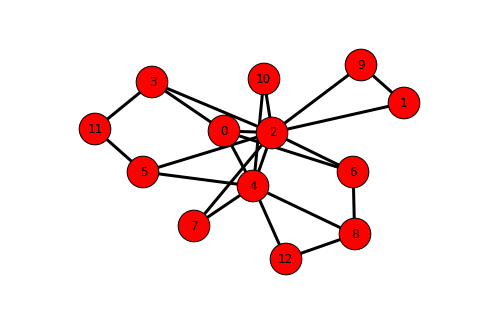

In [64]:
nx.draw(g, with_labels=True, node_size=1000, width=3)

Next, we let a random walker run through the network. At each step, the walker chooses one out-link at random. Overall, we generate 100 trails with a length of 5 for each one.

In [65]:
import numpy as np
from random import choice
#let us create 100 individual trails
i = 100
trails = []
while(i>0):
    #pick random vertex of G
    v = choice(g.nodes())
    trail = []
    trail.append(v)
    #let us try to produce trails with length 5
    x=4
    while x>0:
        #pick random neighbor node
        v = choice(g.neighbors(v))
        trail.append(v)
        x -= 1

    i-=1
    trails.append(trail)

#show some trails
print trails[:10]

[[10, 2, 3, 0, 4], [8, 12, 8, 12, 8], [3, 2, 6, 8, 6], [2, 4, 8, 4, 0], [11, 3, 11, 5, 4], [9, 2, 5, 11, 5], [6, 0, 3, 0, 4], [3, 0, 3, 2, 0], [2, 4, 7, 4, 8], [1, 9, 2, 0, 3]]


Next, we visualize one random walk on the network which ends in one human navigation trail out of the set of 100 trails.

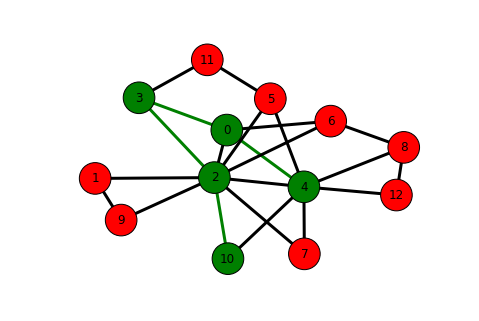

In [66]:
node_colors=[]
for n in g.nodes():
    if n in trails[0]:
        node_colors.append('g')
    else:
        node_colors.append('r')
        
edge_colors=[]
for e in g.edges():
    try:
        idx1 = trails[0].index(e[0])
        idx2 = trails[0].index(e[1])
        if idx1 + 1 == idx2:
            edge_colors.append('g')
        elif idx2 + 1 == idx1:
            edge_colors.append('g')
        else:
            edge_colors.append('black')
    except:
        edge_colors.append('black')
        continue
        
nx.draw(g, with_labels=True, node_size=1000, node_color = node_colors, edge_color = edge_colors, width=3)

###Hypotheses

Now, having the data to study, we want to compare some exemplary hypotheses with each other. Each hypothesis should express a certain belief about the mechanisms producing the trails at hand. Remember that each hypothesis can be expressed via belief in parameters of a Markov chain model. We define some hypotheses next.

In [45]:
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix

####Structural hypothesis

With this hypothesis we want to express our belief that the trails at interest have been generated by humans (or in this case a walker) that randomly chooses hyperlinks to go to the next node---this means that we do not believe in teleportation here.

In [46]:
def struc_prior(paths, vocab, g, ax):

    # We start by creating the hypothesis matrix G
    i_indices = list()
    j_indices = list()
    values = list()
    # Let us iterate through all nodes
    for k,v in vocab.iteritems():
        # Get the neighbors of each node (i.e., those nodes the current node links to)
        # and set the corresponding value of the hypothesis matrix G to 1
        for w in g.neighbors(k):
            i_indices.append(v)
            j_indices.append(vocab[w])
            values.append(1)

    shape_matrix = (max(vocab.itervalues()) + 1, max(vocab.itervalues()) + 1)
    
    # Next we iterate through some values of k (hypothesis weighting factor)
    evidences = {}
    shape = len(vocab)
    for i in xrange(5):
        # If k = 0 then we can simply use an empty matrix
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        # Otherwise, we need to build the hypothesis matrix and elicit the prior
        else:
            # Creating the matrix with above defined values
            matrix_struc = csr_matrix((values, (i_indices, j_indices)),
                             shape=shape_matrix, dtype=np.float64)

            # Here we elicit the Dirichlet prior from expressed hypothesis matrix
            # We use the row-wise (trial) roulette chip distribution (i.e., same amount of chips for each row)
            # chips = number of chips to distribute PER ROW
            # The HypTrails paper suggests to distribute |S|*k chips per row.
            # As we ignore self-loops, we distribute (|S|-1)*k chips per row.
            chips = i*(matrix_struc.shape[0]-1.)
            prior = distr_chips_row(matrix_struc, chips, n_jobs=1)

        # Now, we can pass everything to the Markov chain framework and calculate corresponding evidences
        # k=1 corresponds to the order of the MC (first-order)
        # reset=False can be set to true if we want to work with a reset state (start end end state for each trail)
        # prior=1. corresponds to the initial uniform prior that is necessary for ensuring proper priors
        # specific_prior is our elicited prior
        # specific_prior_vocab is the vocabulary mapping the indices of the prior to the states
        # state_count is the number of states; this ensures the correct number of states (suggested to always set)
        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, state_count=len(vocab), modus="bayes")
        markov.prepare_data(paths)
        markov.fit(paths)

        evidence = markov.bayesian_evidence()
        evidences[i] = evidence
    
    ax.plot(evidences.keys(), evidences.values(), marker='o', clip_on = False, label="structural", linestyle='--')
    return evidences

####Self-loop hypothesis

With this hypothesis, we express the belief that all consecutive steps of a trail consist of the same state. This would simply mean that a walker prefers to consecutively "refresh" the same node over and over. 

In [47]:
def selfloop_prior(paths, vocab, ax):
    
    #The steps are similar to the structural hypothesis described above
    shape = len(vocab)
    evidences = {}
    for i in xrange(5):
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)

        else:
            matrix_selfloop = lil_matrix((shape,shape), dtype=np.float64)
            # As we only believe in self-loops we only believe in transitions from the diagonal of Q
            matrix_selfloop.setdiag(1)
            matrix_selfloop = matrix_selfloop.tocsr()

            chips = i*(matrix_selfloop.shape[0]-1.)
            prior = distr_chips_row(matrix_selfloop, chips, n_jobs=1)

        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, state_count=len(vocab), modus="bayes")
        markov.prepare_data(paths)
        markov.fit(paths)

        evidence = markov.bayesian_evidence()
        evidences[i] = evidence

    ax.plot(evidences.keys(), evidences.values(), marker='o', clip_on = False, label="self-loop", linestyle='-.')
    return evidences

####Uniform hypothesis

We also introduce a uniform hypothesis which should serve as a baseline hypothesis. With this hypothesis, we believe that all transitions are equally likely and thus, we believe that the walker walked randomly through the network. If another hypothesis is not more plausible compared to this uniform one, we might not expect it to explain the underlying mechanisms well. Note though, that a uniform hypothesis might also be a legit mechanism to be interested in itself; for instance in case of teleportation through the network.

In [48]:
def uniform_prior(paths, vocab, ax):

    # In this case we set each element of the hypothesis matrix to the same value
    # We only set the diagonal to zero as we do not consider self-loops
    shape = len(vocab)
    evidences = {}
    for i in xrange(5):
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        else:
            matrix_uniform = lil_matrix((shape,shape), dtype=np.float64)
            matrix_uniform[:] = 1.
            matrix_uniform.setdiag(0.)
            matrix_uniform = matrix_uniform.tocsr()

            chips = i*(matrix_uniform.shape[0]-1.)
            prior = distr_chips_row(matrix_uniform, chips, n_jobs=1)

        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, state_count=len(vocab), modus="bayes")
        
        # If we consider self-loops, the whole process can be done more elegantly. In that case, all elicited
        # Dirichlet pseudo counts receive the same value. Thus, we can directly incorporate this into inference
        # via the prior parameter of the MarkovChain class as this is the pseudo count that each
        # single transition receives.
        # markov = pt.MarkovChain(k=1, use_prior=True, reset = False, prior=1.+i, specific_prior=prior,
        #                        specific_prior_vocab = vocab, modus="bayes")
        
        markov.prepare_data(paths)
        markov.fit(paths)
        evidence = markov.bayesian_evidence()
        evidences[i] = evidence

    ax.plot(evidences.keys(), evidences.values(), marker='o', clip_on = False, label="uniform", linestyle='-')
    return evidences

    

####Data hypothesis

Finally, we express a data hypothesis, which is basically a hypothesis that exactly expresses the data. Thus, this can be seen as an upper limit. We can determine the data hypothesis by taking the MLE of the MC of the data. Note that extracting information from the data and use it as a hypothesis is no valid approach and this example should only provide a better understanding of the relative behavior of various hypotheses.

In [49]:
def data_prior(paths, vocab, ax):
    
    # Again we start by generating the hypothesis matrix G
    shape_matrix = (max(vocab.itervalues()) + 1, max(vocab.itervalues()) + 1)
    evidences = {}
    shape = len(vocab)
    for i in xrange(5):
        if i == 0:
            prior = csr_matrix((shape,shape), dtype=np.float64)
        else:
            # We first calculate the MLE for the data
            markov = MarkovChain(k=1, use_prior=False, reset = False, modus="mle")
            markov.prepare_data(paths)
            markov.fit(paths)
            mle = markov.transition_dict_
            
            # Now we use the parameter configuration from the MLE as a hypothesis
            i_indices = list()
            j_indices = list()
            values = list()
            for s,targets in mle.iteritems():
                for t, v in targets.iteritems():
                    i_indices.append(vocab[s[0]])
                    j_indices.append(vocab[t])
                    values.append(v)

            matrix_data = csr_matrix((values, (i_indices, j_indices)),
                             shape=shape_matrix, dtype=np.float64)
            
            # Typical chip distribution
            chips = i*(matrix_data.shape[0]-1.)
            prior = distr_chips_row(matrix_data, chips, n_jobs=1)

        markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                                specific_prior_vocab = vocab, state_count=len(vocab), modus="bayes")
        markov.prepare_data(paths)
        markov.fit(paths)

        evidence = markov.bayesian_evidence()
        evidences[i] = evidence

    ax.plot(evidences.keys(), evidences.values(), marker='o', clip_on = False, label="data", linestyle='--')
    return evidences

###Comparison

Next, we calculate the evidence for each hypothesis and each hypothesis weighting factor k. We plot the final results.

In [50]:
# This is a simple pipeline for the calculation
def calc(paths, g):

    # First, we need to define the different states that we are interested in and
    # over which we build our hypotheses. In this case, these are simply all nodes
    # of the network. Note that this might also include states that cannot be observed
    # in the data.
    states = set()
    for n in g.nodes():
        states.add(n)
    
    # In this step we build a vocabulary which is important for the HypTrails framework
    # Concretely, we assign an index to each state. So for example, "Node 1": "0"
    # This should match the indices of the matrices that we work with to their corresponding states
    # Thus, this matching has to be kept in mind throughout all steps that follow
    vocab = dict(((t, i) for i, t in enumerate(states)))
    
    # Figure for plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Now, let us calculate the evidences
    print "UNIFORM"
    print "-------"
    ret = uniform_prior(paths, vocab, ax)

    print "STRUCTURAL"
    print "-------"
    ret = struc_prior(paths, vocab, g, ax)
    
    print "DATA"
    print "-------"
    ret = data_prior(paths, vocab, ax)
    
    print "SELF-LOOP"
    print "-------"
    ret = selfloop_prior(paths, vocab, ax)

    # Further plotting
    ax.set_xlabel("hypothesis weighting factor k")
    ax.set_ylabel("marginal likelihood / evidence")

    plt.legend(loc=7, handlelength = 3)
    plt.grid(False)
    ax.xaxis.grid(True)
    plt.tight_layout(pad=0.2)
    plt.show()

UNIFORM
-------
STRUCTURAL
-------
DATA
-------
SELF-LOOP
-------


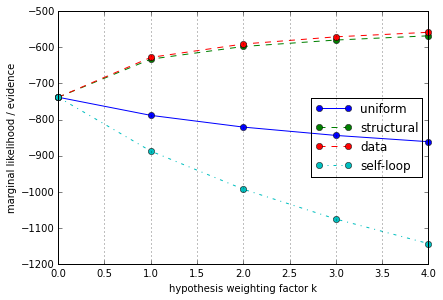

In [51]:
calc(trails, g)

###Results

In above figure, we can see the results for comparing four hypotheses about the production of our synthetic trails at interest; each hypothesis is depicted in a distinct color. The x-axis reports the hypothesis weighting factor $k$ that corresponds to the level of belief in a given hypothesis---the higher the fewer parameter configurations receive corresponding belief in the Dirichlet prior. The y-axis reports the evidence. Note that for simplcity, we now state that higher evidence (for the same values of $k$) mean higher plausibility. For completeness, Bayes factors should be computed to judge the strength of the differences. For details, please resort to the elaboration earlier in this tutorial.

Overall, the results accurately represent what we expected as we know the underlying mechanisms producing the synthetic trails at interest.
First of all, we can see, as expected, that the self-loop hypothesis is for all values of $k>=0$ the least plausible. The reason for that is that our random walker operated on a synthetic network that did not include any self-links and thus, no self-loops are possible to occur in the produced trails. Next, we can see that the data hypothesis is the most plausible which also was to be expected as it is built by taking the MLE of the data. The structural hypothesis describes a good explanation about the production about the synthetic trails at interest as it encodes the strategy of the walker---i.e., choosing any out-link at random at each step. We can see this, as the evidence values for the structural hypothesis are higher compared to the uniform (baseline) hypothesis for all values of $k>0$. 

####Weighting factor k

We can also interpret the progression of the evidence values for single hypothesis with rising $k$. 
The evidences for larger values of $k$ of the self-loop hypothesis are falling. This can be explained by the fact that the self-loop hypothesis believes in transitions that never occur in the data (self-loops). Thus, the stronger we believe in this hypothesis, the less tolerance we give the prior to believe in other parameter configurations and thus, the lower the evidence gets.
We can observe similar behavior for the uniform hypothesis, but not that drastically.
Contrary, the evidences are rising for the structural hypothesis with larger values of $k$. This can be explained by the fact that in this structural hypothesis, we closely capture the mechanisms producing the synthetic trails with our hypothesis matrix $Q$. Thus, the higher we believe in this hypothesis, the stronger we believe in this single configuration, and thus, the higher the evidence gets. This is also the case for the data hypothesis.

Actually, with larger values of $k$, the evidence converges to the simple categorical likelihood that we would receive by just taking the single parameter configuration expressed in the hypothesis matrix $Q$. This is the case, as with higher values of $k$, we limit our belief to this single configuration by increasing the concentration of the Dirichlet prior (see Beta and Dirichlet distribution examples in the first part of this tutorial).

Let us demonstrate this behavior, by taking the MLE of the data as a hypothesis matrix $Q$ (data hypothesis). First, we calculate the log-likelihood of the simple categorical Markov chain model based on the MLE parameters. Remember that the likelihood is determined via:

$$
P(D | \theta) = \prod_i \prod_j p_{i,j}^{n_{i,j}}
$$

In [52]:
markov = MarkovChain(k=1, use_prior=False, reset = False, modus="mle")
markov.prepare_data(trails)
markov.fit(trails)
print markov.loglikelihood()

-499.216430841


Next, let us determine the evidence for some rising values of $k$.

In [53]:
states = set()
for n in g.nodes():
    states.add(n)
    
vocab = dict(((t, i) for i, t in enumerate(states)))

mle = markov.transition_dict_
            
shape_matrix = (max(vocab.itervalues()) + 1, max(vocab.itervalues()) + 1)
i_indices = list()
j_indices = list()
values = list()
for s,targets in mle.iteritems():
    for t, v in targets.iteritems():
        i_indices.append(vocab[s[0]])
        j_indices.append(vocab[t])
        values.append(v)

prior_data = csr_matrix((values, (i_indices, j_indices)),
                 shape=shape_matrix, dtype=np.float64)

for k in [0,1,10,100,1000]:
    chips = k*(prior_data.shape[0]-1)
    prior = distr_chips_row(prior_data, chips, n_jobs=1)

    markov = MarkovChain(k=1, use_prior=True, reset = False, prior=1., specific_prior=prior,
                        specific_prior_vocab = vocab, modus="bayes")
    markov.prepare_data(trails)
    markov.fit(trails)

    evidence = markov.bayesian_evidence()
    print "k:", k, "evidence:", evidence

k: 0 evidence: -738.213824825
k: 1 evidence: -627.753797628
k: 10 evidence: -528.165869974
k: 100 evidence: -502.614787807
k: 1000 evidence: -499.562546168


As expected, the evidence converges to that of the simple log-likelihood calculated for the categorical Markov chain model.

As already mentioned in the first part of this tutorial, in reality it is much more difficult to see rising evidences with higher values of $k$. In this example, this is possible as we synthetically set the hypothesis based on the real mechanisms producing the trails at interest. For a discussion, please resort to the first part of this tutorial and also to Section 5 of our <a href="http://arxiv.org/abs/1411.2844">HypTrails paper</a>. 